In [1]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv("C:/Users/Admin/Downloads/TSLA.csv",sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,1.789333,1.800000,1.726667,1.774667,1.774667,19245000
2011-01-04,1.777333,1.796667,1.734667,1.778000,1.778000,17811000
2011-01-05,1.765333,1.793333,1.746000,1.788667,1.788667,21700500
2011-01-06,1.788667,1.866667,1.787333,1.858667,1.858667,30918000
2011-01-07,1.866667,1.905333,1.860000,1.882667,1.882667,33718500
...,...,...,...,...,...,...
2022-12-30,119.949997,124.480003,119.750000,123.180000,123.180000,157304500
2023-01-03,118.470001,118.800003,104.639999,108.099998,108.099998,231402800
2023-01-04,109.110001,114.589996,107.519997,113.639999,113.639999,180389000


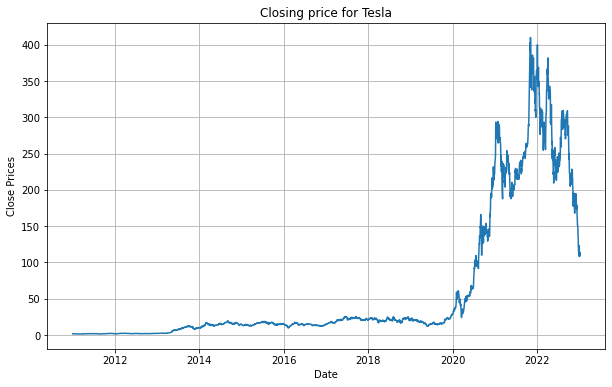

In [3]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('Closing price for Tesla')
plt.show()

<AxesSubplot:ylabel='Density'>

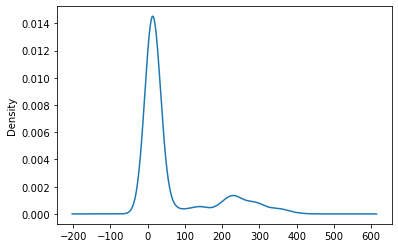

In [4]:
#Distribution of the dataset
df_close=stock_data['Close']
df_close.plot(kind='kde')

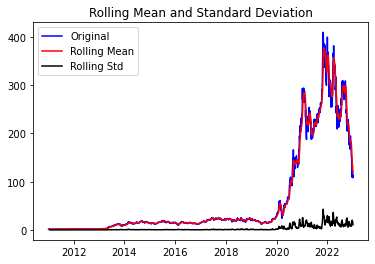

Test Statistics                  -1.400298
p-value                           0.582133
No. of lags used                 29.000000
Number of observations used    2994.000000
critical value (1%)              -3.432536
critical value (5%)              -2.862506
critical value (10%)             -2.567284
dtype: float64


In [5]:
##Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)


<Figure size 432x288 with 0 Axes>

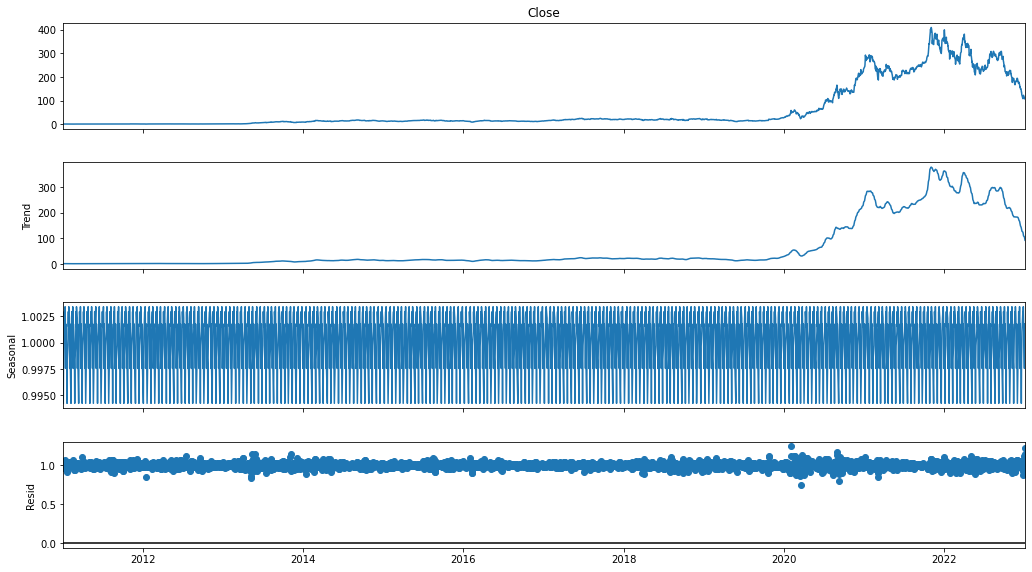

In [6]:
result= seasonal_decompose(df_close, model='multiplicative',extrapolate_trend='freq', period=12)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


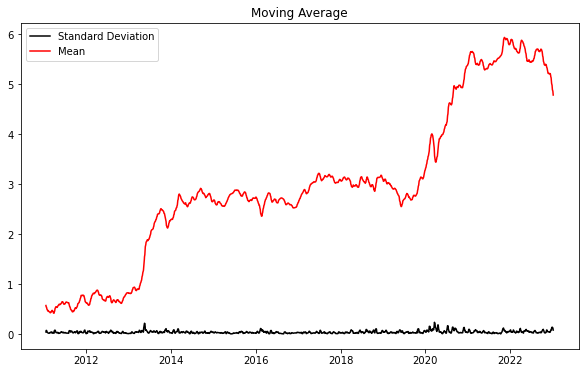

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()


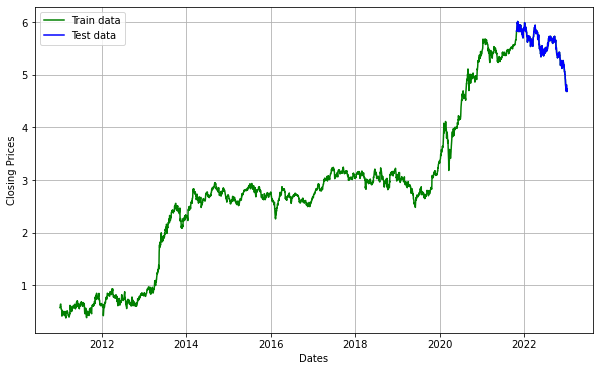

In [8]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10582.477, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10580.862, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10580.855, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10576.457, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10578.523, Time=0.99 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.963 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2718
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5293.238
Date:                Mon, 18 Sep 2023   AIC                         -10582.477
Time:                        18:56:23   BIC                         -10570.662
Sample:                             0   HQIC                        -10578.206
                               - 2718                             

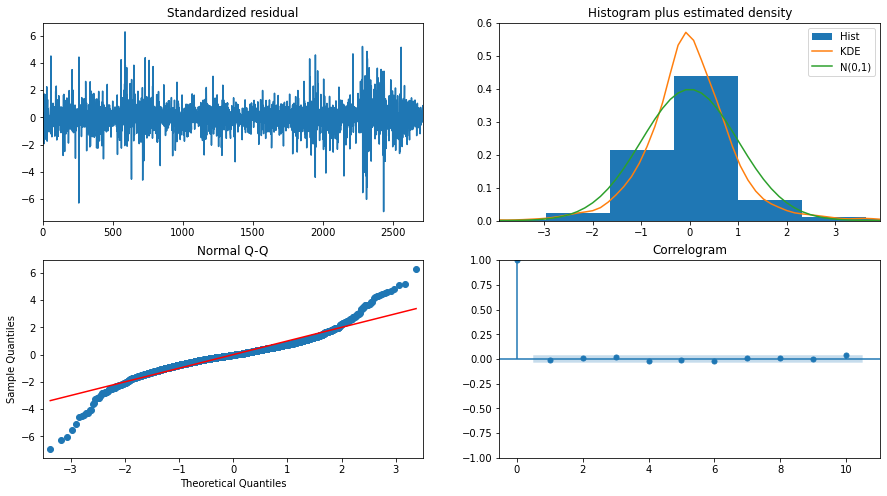

In [9]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [10]:
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))
fitted= model.fit()
print(fitted.summary())

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2718
Model:                 ARIMA(1, 1, 2)   Log Likelihood                5289.534
Date:                Mon, 18 Sep 2023   AIC                         -10571.067
Time:                        18:56:30   BIC                         -10547.438
Sample:                             0   HQIC                        -10562.525
                               - 2718                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0298      1.308      0.023      0.982      -2.535       2.594
ma.L1         -0.0388      1.311     -0.030      0.976      -2.608       2.530
ma.L2          0.0112      0.017      0.659      0.5

In [11]:
forecast=fitted.get_forecast(303, alpha =0.05).summary_frame()
print(forecast)

Close      mean   mean_se  mean_ci_lower  mean_ci_upper
2718   5.714674  0.034531       5.646994       5.782353
2719   5.714877  0.048616       5.619591       5.810163
2720   5.714883  0.059671       5.597931       5.831836
2721   5.714883  0.068982       5.579682       5.850085
2722   5.714883  0.077177       5.563618       5.866148
...         ...       ...            ...            ...
3016   5.714883  0.598444       4.541955       6.887812
3017   5.714883  0.599444       4.539995       6.889772
3018   5.714883  0.600442       4.538038       6.891728
3019   5.714883  0.601439       4.536085       6.893682
3020   5.714883  0.602434       4.534135       6.895632

[303 rows x 4 columns]


C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [12]:
fc_series = pd.Series(forecast['mean'].values, index=test_data.index)
lower_series = pd.Series(forecast['mean_ci_lower'].values, index=test_data.index)
upper_series = pd.Series(forecast['mean_ci_upper'].values, index=test_data.index)

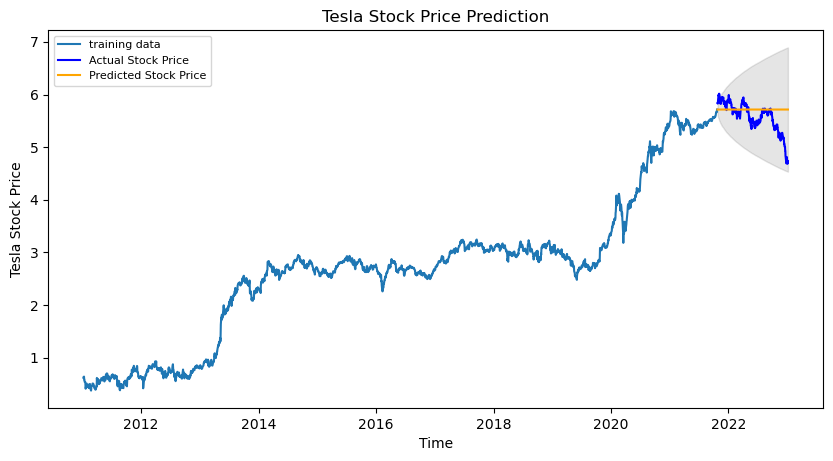

In [13]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [14]:
mse = mean_squared_error(test_data,forecast['mean'].values)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data,forecast['mean'].values)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, forecast['mean'].values))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast['mean'].values - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.09062706310537293
MAE: 0.2148125069913038
RMSE: 0.3010432910818192
MAPE: 0.040257431328287165


# S&P 500

In [15]:
stock_data2= pd.read_csv("C:/Users/Admin/Downloads/s&p_500.csv",sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data2

,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year
Date,,,,,,,,,,
1993-01-29,25.047169,25.047169,24.922556,25.029367,1003200,29,4,4,1,1993
1993-02-01,25.047171,25.207388,25.047171,25.207388,480500,1,0,5,2,1993
1993-02-02,25.189590,25.278599,25.136185,25.260798,201300,2,1,5,2,1993
1993-02-03,25.296384,25.545609,25.278582,25.527807,529400,3,2,5,2,1993
1993-02-04,25.616828,25.688036,25.331999,25.634630,531500,4,3,5,2,1993
...,...,...,...,...,...,...,...,...,...,...
2023-07-24,453.369995,455.040009,452.299988,454.200012,54023400,24,0,30,7,2023
2023-07-25,453.920013,456.739990,453.869995,455.440002,55191200,25,1,30,7,2023
2023-07-26,454.470001,456.989990,453.380005,455.510010,71052900,26,2,30,7,2023


In [16]:
drops= ['Day','Weekday','Week','Month','Year']
for drop in drops:
    stock_data2 = stock_data2.drop(drop, 1)

In [17]:
stock_data2

,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,25.047169,25.047169,24.922556,25.029367,1003200
1993-02-01,25.047171,25.207388,25.047171,25.207388,480500
1993-02-02,25.189590,25.278599,25.136185,25.260798,201300
1993-02-03,25.296384,25.545609,25.278582,25.527807,529400
1993-02-04,25.616828,25.688036,25.331999,25.634630,531500
...,...,...,...,...,...
2023-07-24,453.369995,455.040009,452.299988,454.200012,54023400
2023-07-25,453.920013,456.739990,453.869995,455.440002,55191200
2023-07-26,454.470001,456.989990,453.380005,455.510010,71052900


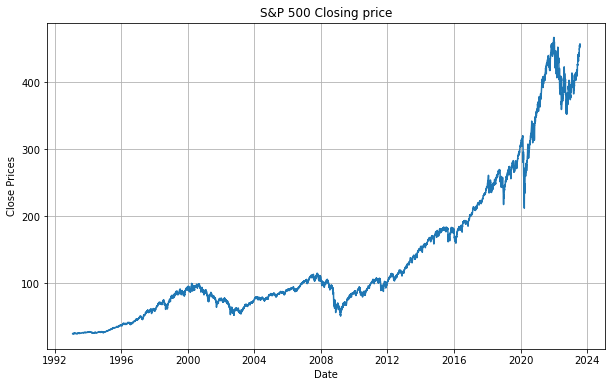

In [18]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data2['Close'])
plt.title('S&P 500 Closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

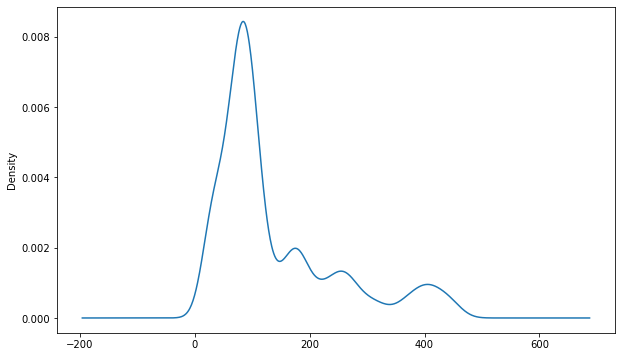

In [19]:
df_close2=stock_data2['Close']
df_close2.plot(kind='kde')

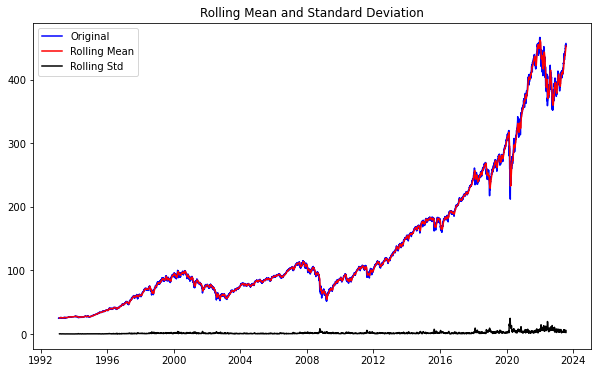

Results of dickey fuller test
Test Statistics                   2.162827
p-value                           0.998850
No. of lags used                 36.000000
Number of observations used    7642.000000
critical value (1%)              -3.431206
critical value (5%)              -2.861918
critical value (10%)             -2.566971
dtype: float64


In [20]:

def test_stationarity(timeseries):
    rolmean2= timeseries.rolling(12).mean()
    rolstd2 = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean2, color='red', label='Rolling Mean')
    plt.plot(rolstd2, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close2)


<Figure size 720x432 with 0 Axes>

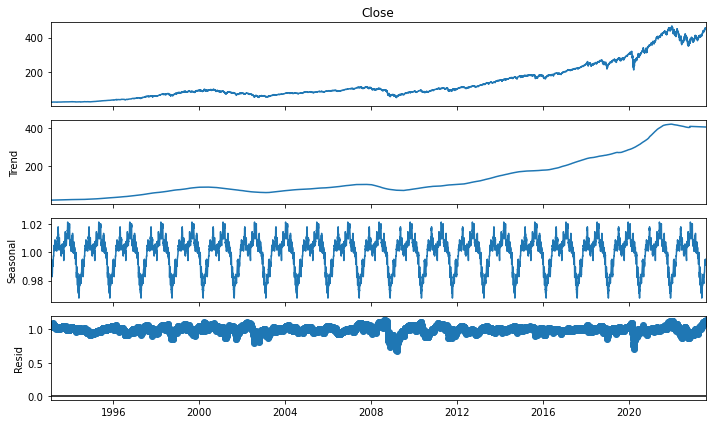

In [21]:
#separate the trend and the seasonality from a time series
result2= seasonal_decompose(df_close2, model='multiplicative',extrapolate_trend='freq', period=365)
fig2 = plt.figure()
fig2 = result2.plot()
fig2.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


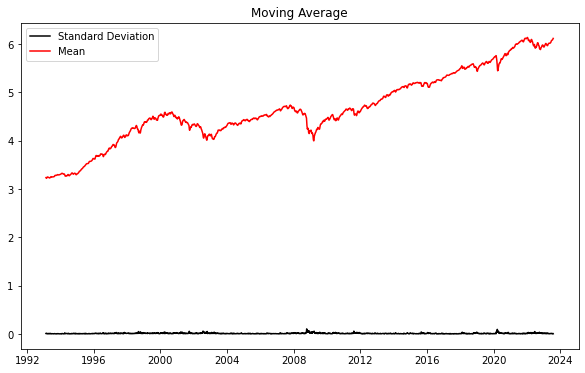

In [22]:
#Eliminate trend

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log2 = np.log(df_close2)
moving_avg2 = df_log2.rolling(12).mean()
std_dev2 = df_log2.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev2, color ="black", label = "Standard Deviation")
plt.plot(moving_avg2, color="red", label = "Mean")
plt.legend()
plt.show()

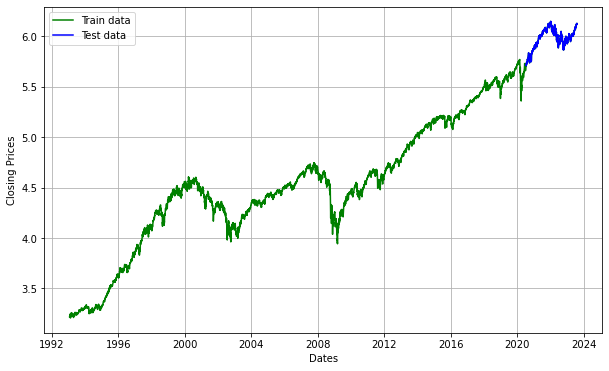

In [23]:
#split data into train and training set
train_data2, test_data2= df_log2[3:int(len(df_log2)*0.9)], df_log2[int(len(df_log2)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log2, 'green', label='Train data')
plt.plot(test_data2, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41566.321, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41618.712, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-41621.469, Time=1.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41562.145, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-41623.131, Time=1.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-41620.334, Time=1.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-41622.632, Time=1.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-41622.625, Time=0.84 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-41622.186, Time=0.74 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-41621.147, Time=1.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-41617.052, Time=0.59 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 9.970 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observati

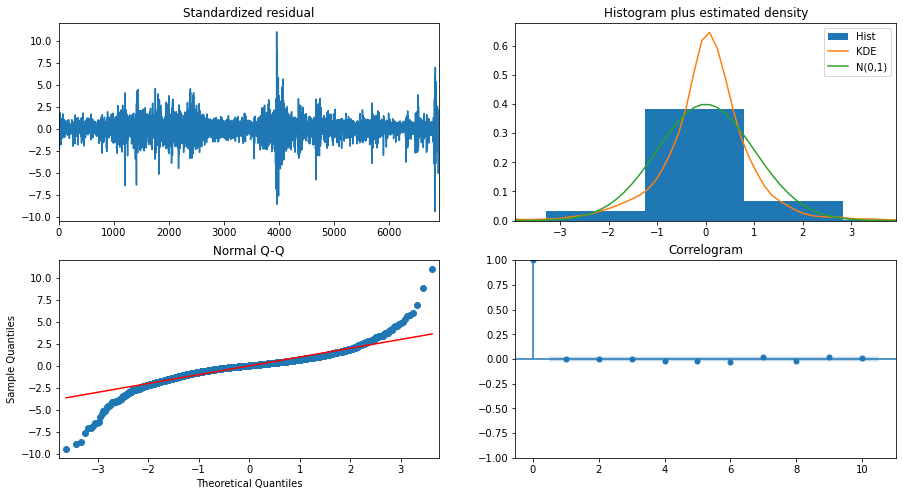

In [26]:
model_autoARIMA2 = auto_arima(train_data2, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA2.summary())
model_autoARIMA2.plot_diagnostics(figsize=(15,8))
plt.show()

In [27]:
import statsmodels.api as sm
model2 = sm.tsa.arima.ARIMA(train_data2, order=(1,1,2))
fitted2 = model2.fit()
print(fitted2.summary())

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6908
Model:                 ARIMA(1, 1, 2)   Log Likelihood               20812.010
Date:                Mon, 18 Sep 2023   AIC                         -41616.020
Time:                        18:58:45   BIC                         -41588.659
Sample:                             0   HQIC                        -41606.586
                               - 6908                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3589      0.210      1.711      0.087      -0.052       0.770
ma.L1         -0.4495      0.208     -2.156      0.031      -0.858      -0.041
ma.L2          0.0118      0.021      0.566      0.5

Close      mean   mean_se  mean_ci_lower  mean_ci_upper
6908   5.705823  0.011889       5.682521       5.729125
6909   5.705877  0.016070       5.674380       5.737375
6910   5.705897  0.019233       5.668201       5.743593
6911   5.705904  0.021902       5.662976       5.748832
6912   5.705907  0.024266       5.658346       5.753468
...         ...       ...            ...            ...
7671   5.705908  0.288350       5.140752       6.271064
7672   5.705908  0.288539       5.140382       6.271434
7673   5.705908  0.288727       5.140013       6.271803
7674   5.705908  0.288916       5.139644       6.272172
7675   5.705908  0.289104       5.139275       6.272541

[768 rows x 4 columns]


C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


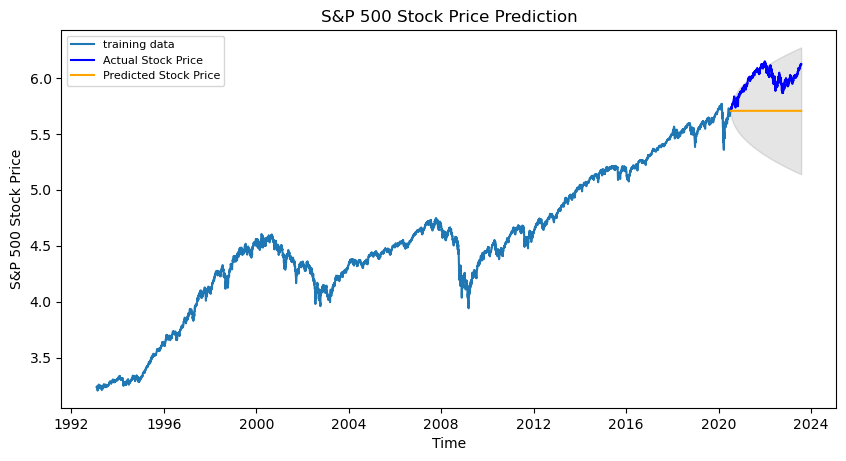

In [28]:
#FORECAST
forecast2=fitted2.get_forecast(768, alpha =0.05).summary_frame()
print(forecast2)


fc_series2 = pd.Series(forecast2['mean'].values, index=test_data2.index)
lower_series2 = pd.Series(forecast2['mean_ci_lower'].values, index=test_data2.index)
upper_series2 = pd.Series(forecast2['mean_ci_upper'].values, index=test_data2.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data2, label='training data')
plt.plot(test_data2, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series2, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series2.index, lower_series2, upper_series2, 
                 color='k', alpha=.10)
plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P 500 Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [29]:
mse2 = mean_squared_error(test_data2,forecast2['mean'].values)
print('MSE: '+str(mse2))
mae2 = mean_absolute_error(test_data2,forecast2['mean'].values)
print('MAE: '+str(mae2))
rmse2 = math.sqrt(mean_squared_error(test_data2, forecast2['mean'].values))
print('RMSE: '+str(rmse2))
mape2 = np.mean(np.abs(forecast2['mean'].values - test_data2)/np.abs(test_data2))
print('MAPE: '+str(mape2))

MSE: 0.0836048859943161
MAE: 0.2711500675392437
RMSE: 0.2891450950549155
MAPE: 0.04509241280391924


# Apple

In [10]:
stock_data3 = pd.read_csv("C:/Users/Admin/Downloads/AppleFinalData.csv",sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data3

,Open,High,Low,Close,Adj Close,compound,neg,neu,pos
Date,,,,,,,,,
2006-12-01,13.1143,13.1900,12.8714,91.32,13.0457,0.7707,0.032,0.905,0.063
2006-12-04,13.1257,13.1500,12.9286,91.12,13.0171,0.8720,0.011,0.904,0.085
2006-12-05,13.0929,13.1900,12.9814,91.27,13.0386,0.0000,0.000,0.000,0.000
2006-12-06,12.9486,13.0557,12.8100,89.83,12.8329,0.6858,0.029,0.878,0.093
2006-12-07,12.8614,12.9286,12.4143,87.04,12.4343,-0.6712,0.091,0.869,0.040
...,...,...,...,...,...,...,...,...,...
2016-11-23,111.3600,111.5100,110.3300,111.23,111.2300,0.0000,0.000,0.000,0.000
2016-11-25,111.1300,111.8700,110.9500,111.79,111.7900,-0.8990,0.115,0.885,0.000
2016-11-28,111.4300,112.4700,111.3900,111.57,111.5700,0.0000,0.000,0.000,0.000


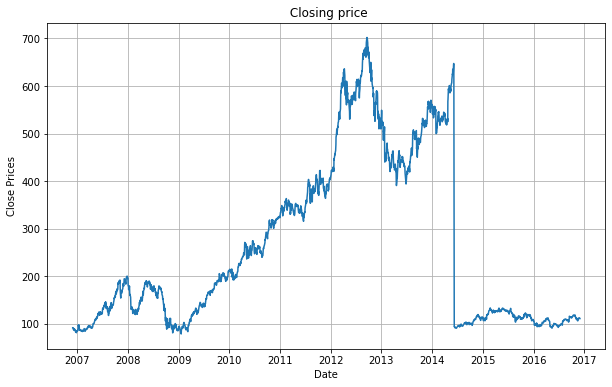

In [11]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data3['Close'])
plt.title(' Closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

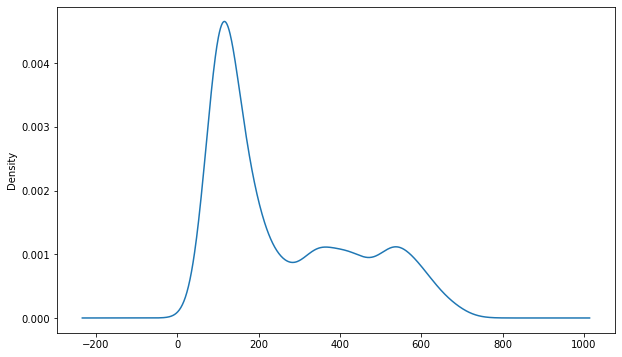

In [12]:
df_close3=stock_data3['Close']
df_close3.plot(kind='kde')

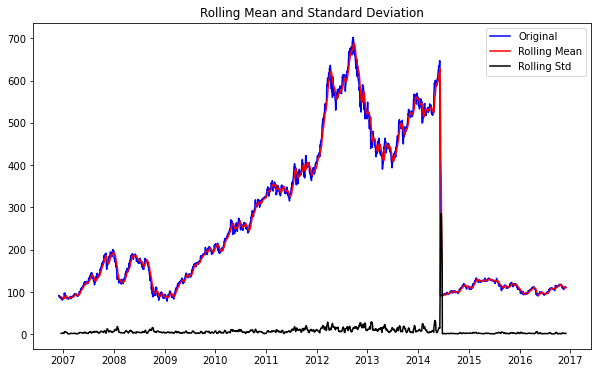

Results of dickey fuller test
Test Statistics                  -1.794862
p-value                           0.383016
No. of lags used                  0.000000
Number of observations used    2516.000000
critical value (1%)              -3.432952
critical value (5%)              -2.862689
critical value (10%)             -2.567382
dtype: float64


In [13]:
def test_stationarity(timeseries):
    rolmean3= timeseries.rolling(12).mean()
    rolstd3= timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean3, color='red', label='Rolling Mean')
    plt.plot(rolstd3, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft3 = adfuller(timeseries,autolag='AIC')
    output3 = pd.Series(adft3[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft3[4].items():
        output3['critical value (%s)'%key] =  values
    print(output3)
test_stationarity(df_close3)

<Figure size 720x432 with 0 Axes>

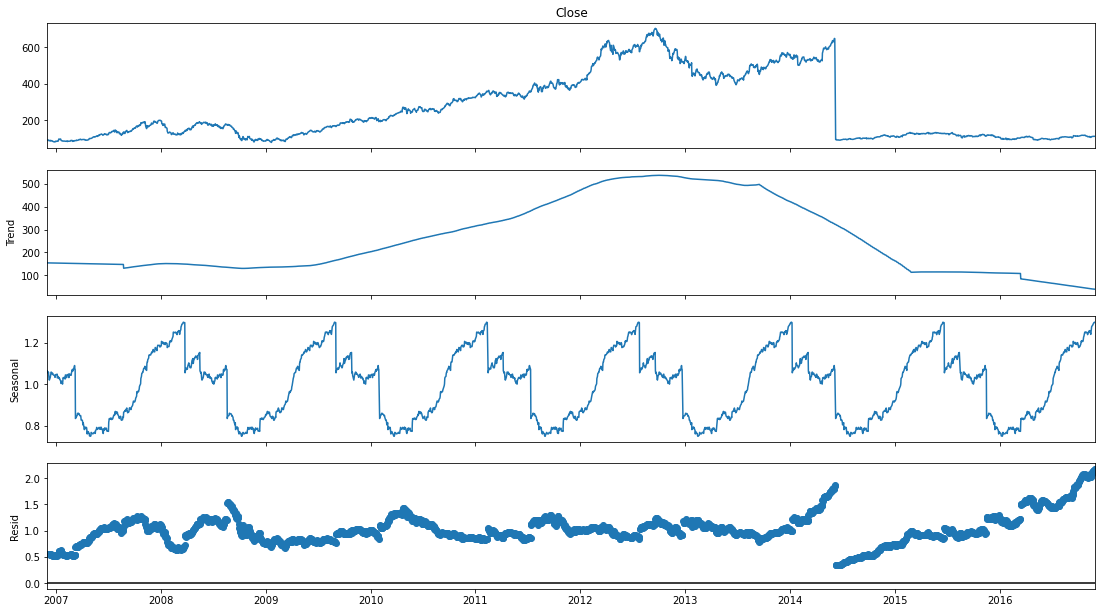

In [14]:
result3= seasonal_decompose(df_close3, model='multiplicative',extrapolate_trend='freq', period=365)
fig3 = plt.figure()
fig3 = result3.plot()
fig3.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


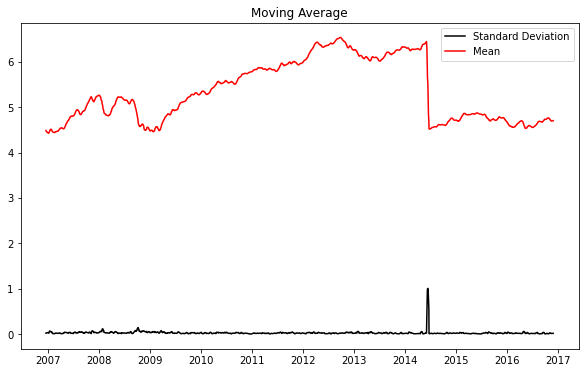

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log3 = np.log(df_close3)
moving_avg3 = df_log3.rolling(12).mean()
std_dev3 = df_log3.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev3, color ="black", label = "Standard Deviation")
plt.plot(moving_avg3, color="red", label = "Mean")
plt.legend()
plt.show()

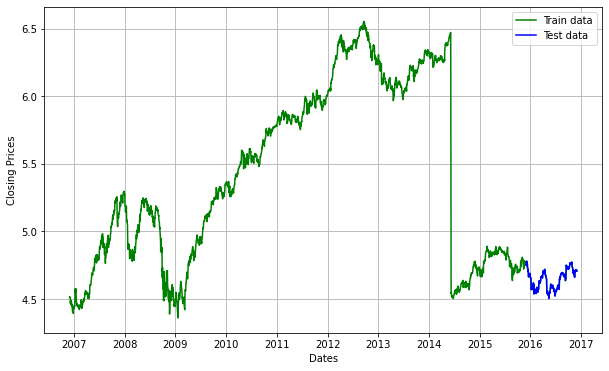

In [16]:
train_data3, test_data3= df_log3[3:int(len(df_log3)*0.9)], df_log3[int(len(df_log3)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log3, 'green', label='Train data')
plt.plot(test_data3, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7513.972, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7511.975, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7511.975, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7515.957, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7509.981, Time=0.66 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.588 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2262
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3758.978
Date:                Tue, 10 Oct 2023   AIC                          -7515.957
Time:                        11:27:54   BIC                          -7510.233
Sample:                             0   HQIC                         -7513.868
                               - 2262                                  

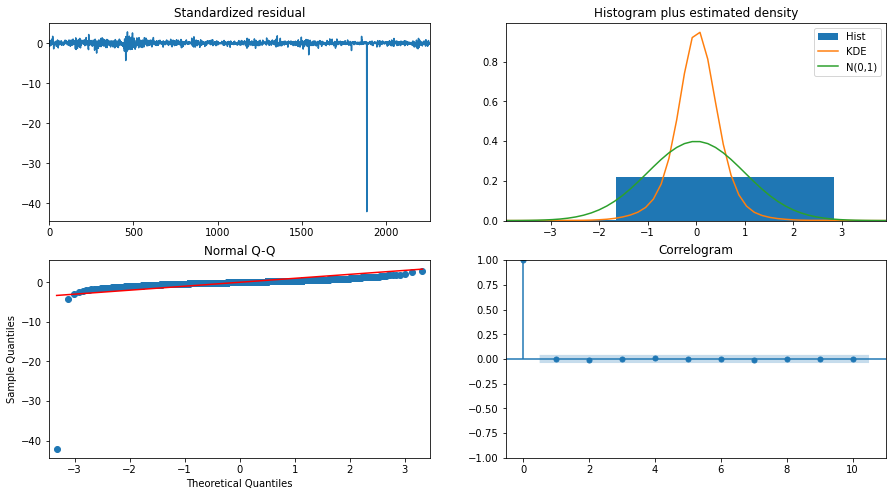

In [17]:
model_autoARIMA3 = auto_arima(train_data3, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA3.summary())
model_autoARIMA3.plot_diagnostics(figsize=(15,8))
plt.show()

In [18]:
import statsmodels.api as sm
model3 = sm.tsa.arima.ARIMA(train_data3, order=(1,1,2))
fitted3 = model3.fit()
print(fitted3.summary())

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2262
Model:                 ARIMA(1, 1, 2)   Log Likelihood                3759.048
Date:                Tue, 10 Oct 2023   AIC                          -7510.095
Time:                        11:28:30   BIC                          -7487.201
Sample:                             0   HQIC                         -7501.741
                               - 2262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0587      5.509      0.011      0.991     -10.739      10.856
ma.L1         -0.0596      5.508     -0.011      0.991     -10.856      10.736
ma.L2         -0.0079      0.044     -0.180      0.8

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Close      mean   mean_se  mean_ci_lower  mean_ci_upper
2262   4.765051  0.045890       4.675108       4.854994
2263   4.765114  0.064871       4.637970       4.892258
2264   4.765118  0.079229       4.609832       4.920403
2265   4.765118  0.091347       4.586082       4.944155
2266   4.765118  0.102035       4.565133       4.965103
...         ...       ...            ...            ...
2509   4.765118  0.716013       3.361758       6.168478
2510   4.765118  0.717455       3.358932       6.171304
2511   4.765118  0.718894       3.356112       6.174124
2512   4.765118  0.720330       3.353297       6.176939
2513   4.765118  0.721763       3.350488       6.179748

[252 rows x 4 columns]


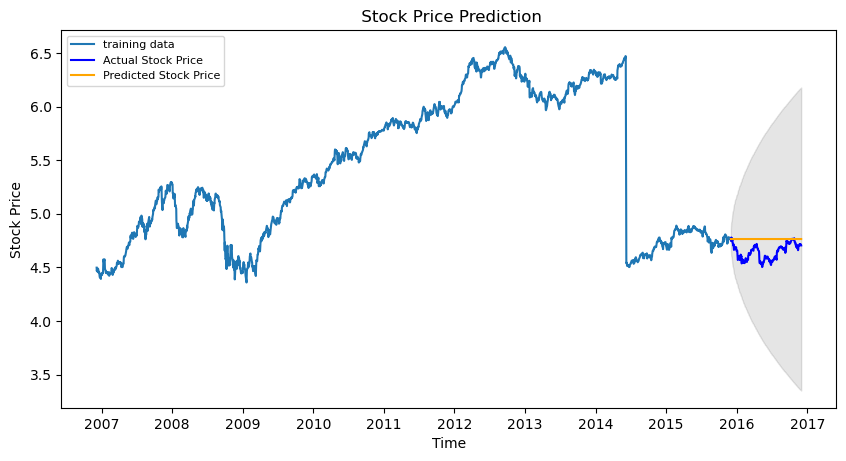

In [28]:
forecast3=fitted3.get_forecast(252, alpha =0.05).summary_frame()
print(forecast3)


fc_series3 = pd.Series(forecast3['mean'].values, index=test_data3.index)
lower_series3 = pd.Series(forecast3['mean_ci_lower'].values, index=test_data3.index)
upper_series3 = pd.Series(forecast3['mean_ci_upper'].values, index=test_data3.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data3, label='training data')
plt.plot(test_data3, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series3, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series3.index, lower_series3, upper_series3, 
                 color='k', alpha=.10)
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
mse3 = mean_squared_error(test_data3,forecast3['mean'].values)
print('MSE: '+str(mse3))
mae3 = mean_absolute_error(test_data3,forecast3['mean'].values)
print('MAE: '+str(mae3))
rmse3 = math.sqrt(mean_squared_error(test_data3, forecast3['mean'].values))
print('RMSE: '+str(rmse3))
mape3 = np.mean(np.abs(forecast3['mean'].values - test_data3)/np.abs(test_data3))
print('MAPE: '+str(mape3))

MSE: 0.019414786838168063
MAE: 0.12012180016216006
RMSE: 0.13933695431639112
MAPE: 0.026097670864409048


# Microsoft

In [43]:
stock_data4 = pd.read_csv("C:/Users/Admin/Downloads/MicrosoftFinalData2.csv",sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data4

,Open,High,Low,Close,Adj Close,compound,neg,neu,pos
Date,,,,,,,,,
2006-12-01,29.23,29.30,28.90,29.12,29.12,0.0000,0.000,0.000,0.000
2006-12-04,29.23,29.52,29.17,29.33,29.33,-0.7783,0.137,0.863,0.000
2006-12-05,29.36,29.40,29.03,29.13,29.13,0.0000,0.000,0.000,0.000
2006-12-06,29.10,29.13,28.87,28.99,28.99,0.9003,0.051,0.847,0.102
2006-12-07,28.96,29.07,28.81,28.85,28.85,0.6597,0.000,0.810,0.190
...,...,...,...,...,...,...,...,...,...
2016-11-23,61.01,61.10,60.25,60.40,60.40,0.8478,0.000,0.842,0.158
2016-11-25,60.30,60.53,60.13,60.53,60.53,0.0000,0.000,0.000,0.000
2016-11-28,60.34,61.02,60.21,60.61,60.61,0.0000,0.000,0.000,0.000


In [57]:
stock_data4.drop(['compound','neg','neu','pos'], axis=1,inplace=True)
stock_data4

,Open,High,Low,Close,Adj Close
Date,,,,,
2006-12-01,29.23,29.30,28.90,29.12,29.12
2006-12-04,29.23,29.52,29.17,29.33,29.33
2006-12-05,29.36,29.40,29.03,29.13,29.13
2006-12-06,29.10,29.13,28.87,28.99,28.99
2006-12-07,28.96,29.07,28.81,28.85,28.85
...,...,...,...,...,...
2016-11-23,61.01,61.10,60.25,60.40,60.40
2016-11-25,60.30,60.53,60.13,60.53,60.53
2016-11-28,60.34,61.02,60.21,60.61,60.61


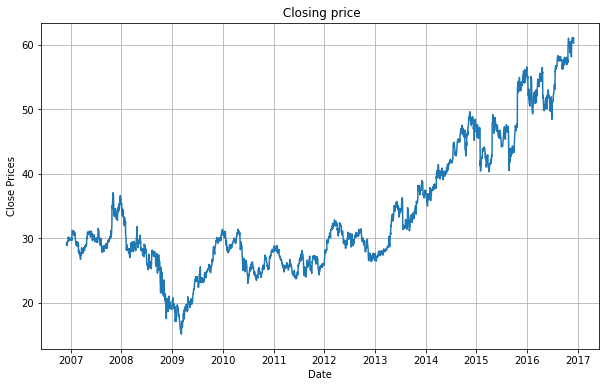

In [58]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data4['Close'])
plt.title(' Closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

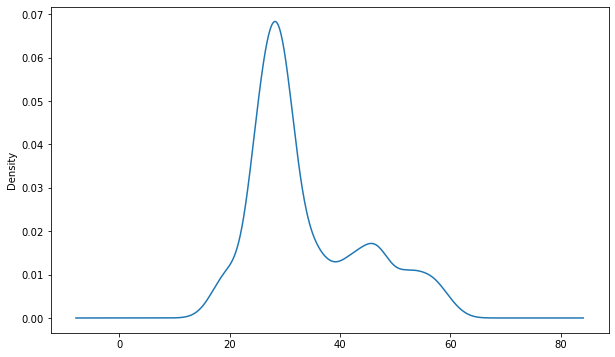

In [59]:
df_close4=stock_data4['Close']
df_close4.plot(kind='kde')

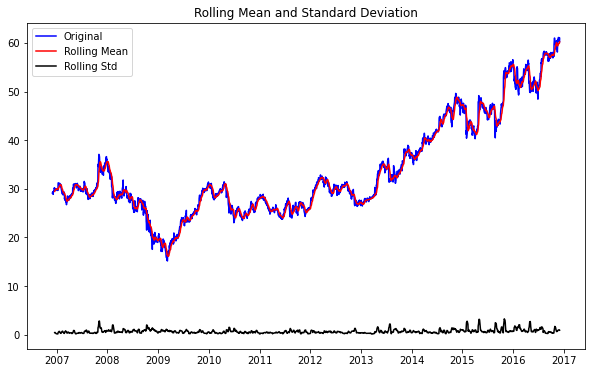

Results of dickey fuller test
Test Statistics                   0.262984
p-value                           0.975581
No. of lags used                 11.000000
Number of observations used    2505.000000
critical value (1%)              -3.432963
critical value (5%)              -2.862694
critical value (10%)             -2.567385
dtype: float64


In [60]:
def test_stationarity(timeseries):
    rolmean4= timeseries.rolling(12).mean()
    rolstd4= timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean4, color='red', label='Rolling Mean')
    plt.plot(rolstd4, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft4 = adfuller(timeseries,autolag='AIC')
    output4 = pd.Series(adft4[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft4[4].items():
        output4['critical value (%s)'%key] =  values
    print(output4)
test_stationarity(df_close4)

<Figure size 720x432 with 0 Axes>

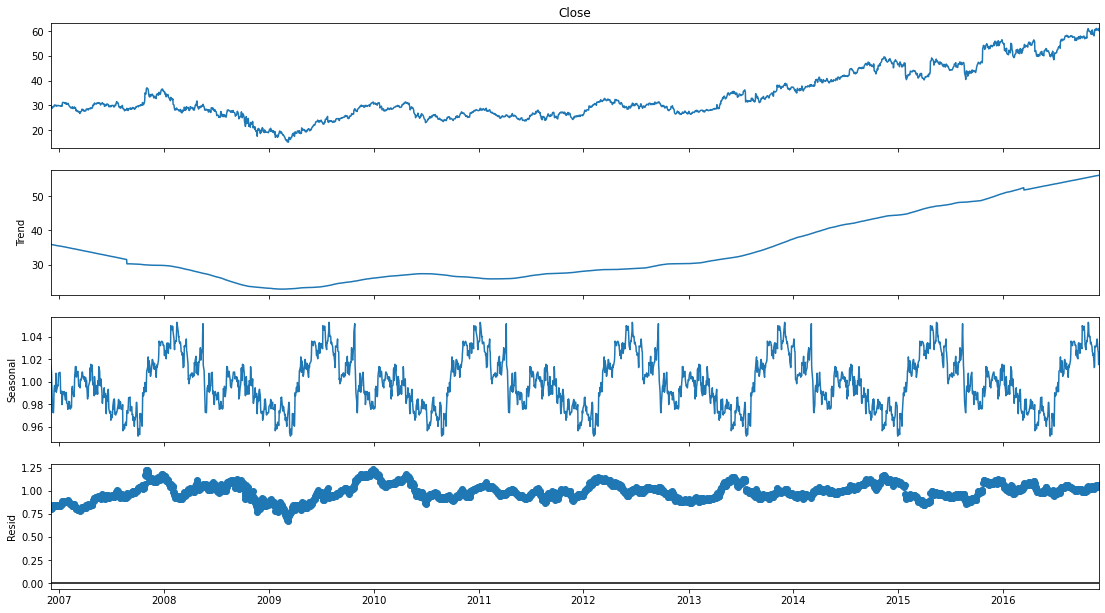

In [61]:
result4= seasonal_decompose(df_close4, model='multiplicative',extrapolate_trend='freq', period=365)
fig4 = plt.figure()
fig4 = result4.plot()
fig4.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


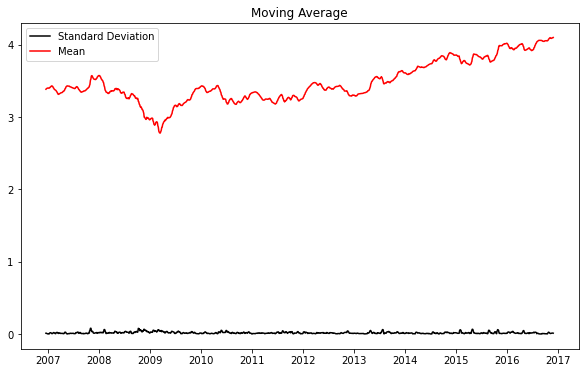

In [62]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log4 = np.log(df_close4)
moving_avg4 = df_log4.rolling(12).mean()
std_dev4 = df_log4.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev4, color ="black", label = "Standard Deviation")
plt.plot(moving_avg4, color="red", label = "Mean")
plt.legend()
plt.show()

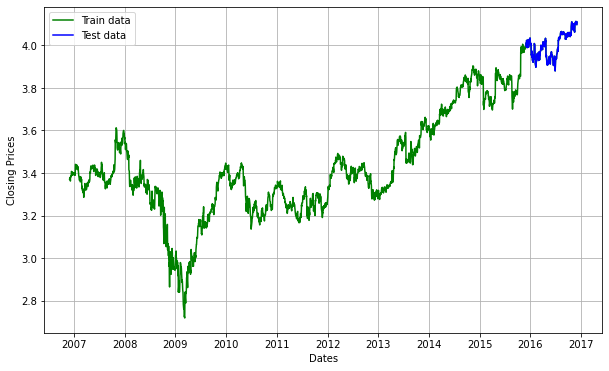

In [63]:
train_data4, test_data4= df_log4[3:int(len(df_log4)*0.9)], df_log4[int(len(df_log4)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log4, 'green', label='Train data')
plt.plot(test_data4, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11712.496, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11717.301, Time=0.73 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11718.086, Time=1.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11713.938, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11717.945, Time=1.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11723.223, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11723.613, Time=2.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11721.658, Time=2.91 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-11721.429, Time=1.95 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-11722.946, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11725.534, Time=1.68 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11723.105, Time=1.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-11721.291, Time=2.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-11723.575, Time=0.57 sec
 ARIM

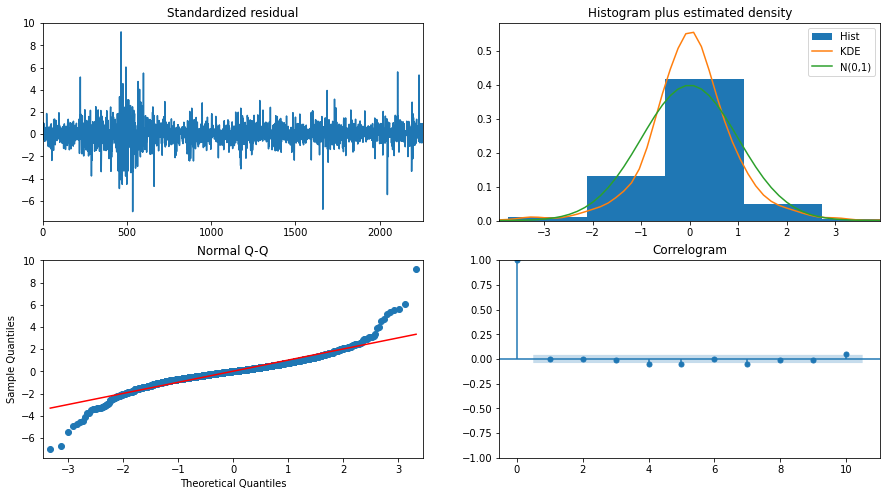

In [64]:
model_autoARIMA4 = auto_arima(train_data4, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA4.summary())
model_autoARIMA4.plot_diagnostics(figsize=(15,8))
plt.show()

In [65]:
import statsmodels.api as sm
model4 = sm.tsa.arima.ARIMA(train_data4, order=(1,1,2))
fitted4 = model4.fit()
print(fitted4.summary())

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2262
Model:                 ARIMA(1, 1, 2)   Log Likelihood                5866.350
Date:                Tue, 10 Oct 2023   AIC                         -11724.699
Time:                        18:47:25   BIC                         -11701.805
Sample:                             0   HQIC                        -11716.345
                               - 2262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2520      0.254     -0.991      0.322      -0.751       0.246
ma.L1          0.1958      0.256      0.766      0.444      -0.305       0.697
ma.L2         -0.0698      0.018     -3.933      0.0

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Close      mean   mean_se  mean_ci_lower  mean_ci_upper
2262   4.010071  0.018067       3.974660       4.045482
2263   4.009223  0.024842       3.960533       4.057913
2264   4.009437  0.029573       3.951474       4.067400
2265   4.009383  0.033767       3.943200       4.075566
2266   4.009397  0.037467       3.935962       4.082831
...         ...       ...            ...            ...
2509   4.009394  0.256031       3.507583       4.511205
2510   4.009394  0.256546       3.506573       4.512214
2511   4.009394  0.257060       3.505566       4.513222
2512   4.009394  0.257573       3.504561       4.514227
2513   4.009394  0.258085       3.503557       4.515230

[252 rows x 4 columns]


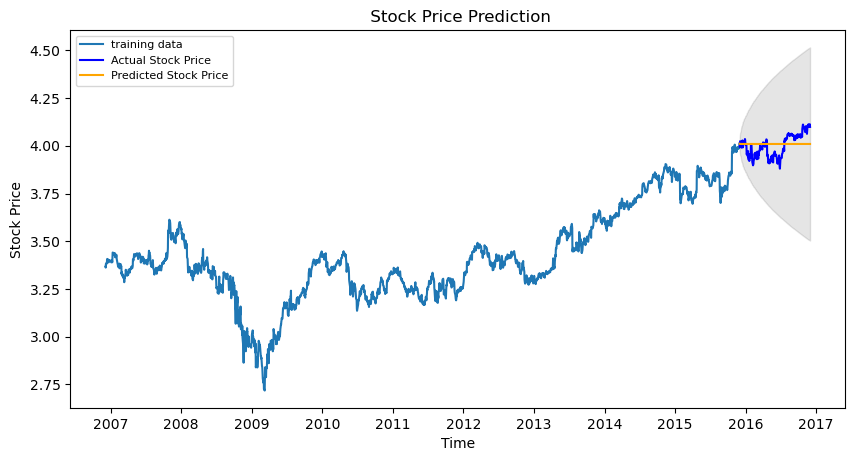

In [66]:
forecast4=fitted4.get_forecast(252, alpha =0.05).summary_frame()
print(forecast4)


fc_series4 = pd.Series(forecast4['mean'].values, index=test_data4.index)
lower_series4 = pd.Series(forecast4['mean_ci_lower'].values, index=test_data4.index)
upper_series4 = pd.Series(forecast4['mean_ci_upper'].values, index=test_data4.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data4, label='training data')
plt.plot(test_data4, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series4, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series4.index, lower_series4, upper_series4, 
                 color='k', alpha=.10)
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [68]:
mse4 = mean_squared_error(test_data4,forecast4['mean'].values)
print('MSE: '+str(mse4))
mae4 = mean_absolute_error(test_data4,forecast4['mean'].values)
print('MAE: '+str(mae4))
rmse4 = math.sqrt(mean_squared_error(test_data4, forecast4['mean'].values))
print('RMSE: '+str(rmse4))
mape4 = np.mean(np.abs(forecast4['mean'].values - test_data4)/np.abs(test_data4))
print('MAPE: '+str(mape4))

MSE: 0.0035193886046823537
MAE: 0.05122863079428966
RMSE: 0.059324435140019276
MAPE: 0.012840082291659739
